In [198]:
import pandas as pd
import numpy as np
import re
import os
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, BatchNormalization
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray
from numpy import zeros
import tensorflow as tf
import keras.backend as K
from tensorflow.python.keras import backend as K2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import yaml

In [195]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [196]:
stop_words = set(stopwords.words('english'))
stop_words.add("br")
stop_words.add("wikipedia")
stop_words.add("url")

In [230]:
train_data = pd.read_csv('train.csv',sep=',', encoding='ISO-8859-1')
test_data  = pd.read_csv('multiLabelTest.csv',sep=',', encoding='ISO-8859-1')
np.shape(train_data)

(159571, 8)

In [231]:
slang_dict=pd.read_csv('slangDict.csv')
slang_dict_map = dict(zip(slang_dict['slang'], slang_dict['word']))

In [232]:
train_data = train_data.drop('id', axis=1)

In [233]:
test_data.columns = train_data.columns

In [234]:
train_data = train_data[train_data['comment_text'] != "" ]
test_data = test_data[test_data['comment_text'] != "" ]
train_data['comment_text'] = train_data['comment_text'].fillna("")
test_data['comment_text'] = test_data['comment_text'].fillna("")

In [235]:
rowsums=train_data.iloc[:,1:].sum(axis=1)

In [238]:
train_data['clean']=(rowsums==0)

In [251]:
x=train_data['clean'].value_counts()

In [258]:
train_data['clean'].sum()
print("Total comments = ",len(train_data))
print("Total clean comments = ",train_data['clean'].sum())
print("Total comments with abusive labels =",x[0])


Total comments =  159571
Total clean comments =  143346
Total comments with abusive labels = 16225


In [7]:
train_y=train_data.iloc[:,1:7]

In [8]:
test_y=test_data.iloc[:,1:7]

In [9]:
def clean_data(temp_ds,str_idx):
    x=temp_ds.iloc[:,str_idx:].sum()
    rowsums=temp_ds.iloc[:,str_idx:].sum(axis=1)
    temp_ds['clean']=(rowsums==0)
    
    df_majority = temp_ds[temp_ds.clean==True]
    df_minority = temp_ds[temp_ds.clean==False]

    df_majority = df_majority.sample(frac = 1)
    df_majority_downsampled = df_majority.head(40000)

    temp_ds = pd.concat([df_majority_downsampled,df_minority])
    temp_ds = temp_ds.drop('clean', axis=1)
    return temp_ds

In [10]:
def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

In [11]:
def preprocessor(text, lemmatizer, stemmer, retainNumbers):
    import re
    from nltk import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    import sys
    import pandas as pd
    
    text = normalize_slang(text)
    text = re.sub(r'((www\.[^\s]+)|(http)\S+)', '',text)
    retweet_user = ['rt', 'user']
    for word in retweet_user:
        text = re.sub(word,'', text)
        text = re.sub(word.upper(),' ',text)
        #text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
    
    
    if pd.isnull(text) == True:
        return ""

    if retainNumbers == True:
        #remove any character not in the listed range
        text = re.sub("[^0-9a-zA-Z\.]+", " ", text)
    else:
        text = re.sub("[^a-zA-Z]+", " ", text)

    #remove extra whitespace
    text = re.sub("\s+", " ", text)
    text = text.lower()
    text = [word for word in text.split() if word not in stop_words]

    #split text

    # http://www.nltk.org/api/nltk.stem.html#nltk.stem.wordnet.WordNetLemmatizer
    if(lemmatizer == True):

        try:
            wordnet_lemmatizer = WordNetLemmatizer()
            newText = ""
            for word in text.split():
                newText = " ".join((newText, wordnet_lemmatizer.lemmatize(word)))
            text = newText.strip(" ")
            #text = wordnet_lemmatizer.lemmatize(text)
        except Exception as e:
            print(e)
            print("--- downloading nltk wordnet corpora")
            import nltk
            nltk.download('wordnet')
            newText = ""

            for word in text.split():
                newText = " ".join((newText, wordnet_lemmatizer.lemmatize(word)))
            text = newText.strip(" ")

    #http://www.nltk.org/howto/stem.html
    if (stemmer == True):
        try:
            stm = SnowballStemmer("english")
            newText = ""
            for word in text.split():
                newText = " ".join((newText, stm.stem(word)))
            text = newText.strip(" ")
        except Exception as e:
            print(e)
            print("--- downloading nltk snowball data")
            import nltk
            nltk.download('snowball_data')
            newText = ""
            for word in text.split():
                newText = " ".join((newText, stm.stem(word)))
            text = newText.strip(" ")

    return text

In [13]:
def get_GloVeEmbedding(embedding_matrix,tokenizer_items):
    
    embeddings_index = {}
    glovefile = open('glove.6B.200d.txt','r',encoding='utf-8')
    for line in glovefile:
        values = line.split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
#     coefs.shape
        embeddings_index[word] = coefs
    glovefile.close()
            
            
    return embedding_matrix,skipped_words

In [14]:
def GolveWordEmbeddingIndex():  
    embeddings_index = {}
    glovefile = open('glove.6B.200d.txt','r',encoding='utf-8')
    for line in glovefile:
        values = line.split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    glovefile.close()
    return embeddings_index


In [16]:

def get_GloveEmbeddingVector(embedding_matrix,embeddings_index,tokenizer_items):
    for word, index in tokenizer_items:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix


In [89]:
def TextPreprocessing_FeatureExtraction(train_data,test_data):
    
    retainNumbers = False
    useStemming = False
    useLemma = True

    train_data['comment_text'] = train_data['comment_text'].apply(preprocessor, args=(useLemma, useStemming, retainNumbers))
    test_data['comment_text'] = test_data['comment_text'].apply(preprocessor, args=(useLemma, useStemming, retainNumbers))
    
    
    train_data = train_data['comment_text'].values.ravel()
    test_data = test_data['comment_text'].values.ravel()
    
    tokenizer = Tokenizer(num_words=90000, oov_token='<oov>')
    tokenizer.fit_on_texts(train_data)
    
    train_data = tokenizer.texts_to_sequences(train_data)
    test_data = tokenizer.texts_to_sequences(test_data)
    
    vocab_size = len(tokenizer.word_index) + 1
    
    maxlen = 1000
    #Getting maximum number of words in text for padding
    #maxlen = max([len(x) for x in np.array(train_data)])
    
    train_data = pad_sequences(train_data, padding='pre', maxlen=maxlen)
    test_data = pad_sequences(test_data, padding='pre', maxlen=maxlen)
    
    glove_Embedding_Index=GolveWordEmbeddingIndex()
    embedding_matrix=np.zeros((vocab_size,200)) 
    embedding_matrix=get_GloveEmbeddingVector(embedding_matrix,glove_Embedding_Index,tokenizer.word_index.items())
    
    return train_data,test_data,vocab_size, maxlen,embedding_matrix,tokenizer
    
        

In [92]:
train_X,test_X,vocab_size,maxlen,embedding_matrix,tokenizer = TextPreprocessing_FeatureExtraction(train_data,test_data)

In [21]:
def Custom_Hamming_Loss(y_true, y_pred):
    tmp = K.abs(y_true-y_pred)
    return K.mean(K.cast(K.greater(tmp,0.5),dtype=float))

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False,input_length=maxlen))
model.add(LSTM(128))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',Custom_Hamming_Loss])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          30559800  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 30,729,022
Trainable params: 169,222
Non-trainable params: 30,559,800
_________________________________________________________________


In [23]:
history = model.fit(train_X, np.array(train_y), batch_size=512, epochs=20, verbose=1,validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 617s 2s/step - loss: 0.1665 - acc: 0.9773 - Custom_Hamming_Loss: 0.0511 - val_loss: 0.0654 - val_acc: 0.9941 - val_Custom_Hamming_Loss: 0.0223
Epoch 2/20
250/250 [==============================] - 592s 2s/step - loss: 0.0614 - acc: 0.9941 - Custom_Hamming_Loss: 0.0217 - val_loss: 0.0587 - val_acc: 0.9941 - val_Custom_Hamming_Loss: 0.0205
Epoch 3/20
250/250 [==============================] - 596s 2s/step - loss: 0.0558 - acc: 0.9940 - Custom_Hamming_Loss: 0.0201 - val_loss: 0.0573 - val_acc: 0.9941 - val_Custom_Hamming_Loss: 0.0199
Epoch 4/20
250/250 [==============================] - 599s 2s/step - loss: 0.0542 - acc: 0.9931 - Custom_Hamming_Loss: 0.0194 - val_loss: 0.0547 - val_acc: 0.9939 - val_Custom_Hamming_Loss: 0.0191
Epoch 5/20
250/250 [==============================] - 600s 2s/step - loss: 0.0502 - acc: 0.9940 - Custom_Hamming_Loss: 0.0181 - val_loss: 0.0536 - val_acc: 0.9917 - val_Custom_Hamming_Loss: 0.0186
Epoch 6/20
250/

dict_keys(['loss', 'acc', 'Custom_Hamming_Loss', 'val_loss', 'val_acc', 'val_Custom_Hamming_Loss'])


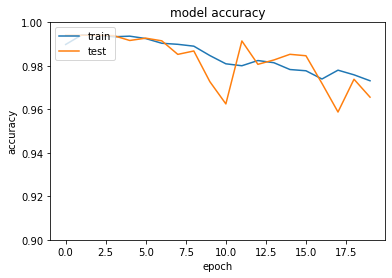

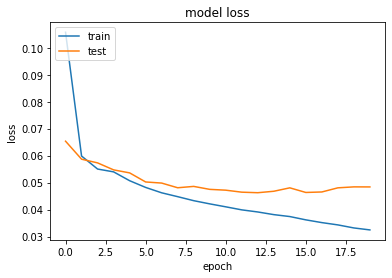

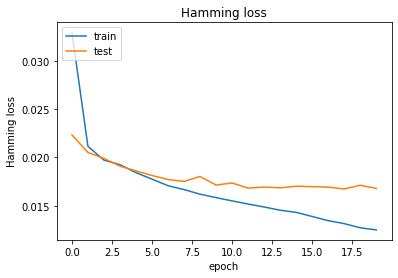

In [26]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.9, 1])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for Hamming loss
plt.plot(history.history['Custom_Hamming_Loss'])
plt.plot(history.history['val_Custom_Hamming_Loss'])
plt.title('Hamming loss')
plt.ylabel('Hamming loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
#evaluate model using the latest model
score = model.evaluate(test_X, np.array(test_y), verbose=1)

print("Test Loss Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Hamming loss:", score[2])

2000/2000 [==============================] - 166s 83ms/step - loss: 0.0738 - acc: 0.9614 - Custom_Hamming_Loss: 0.0284
Test Loss Score: 0.0737638920545578
Test Accuracy: 0.9613773226737976
Test Hamming loss: 0.02842240035533905


In [34]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
# model checkpoint
mc = ModelCheckpoint('simple_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history_es = model.fit(train_X, np.array(train_y), batch_size=512, epochs=20, verbose=1,validation_split=0.2,callbacks=[es,mc])

Epoch 1/20
250/250 [==============================] - 742s 3s/step - loss: 0.0314 - acc: 0.9693 - Custom_Hamming_Loss: 0.0121 - val_loss: 0.0479 - val_acc: 0.9723 - val_Custom_Hamming_Loss: 0.0173

Epoch 00001: val_loss improved from inf to 0.04791, saving model to simple_lstm.h5
Epoch 2/20
250/250 [==============================] - 719s 3s/step - loss: 0.0306 - acc: 0.9629 - Custom_Hamming_Loss: 0.0117 - val_loss: 0.0495 - val_acc: 0.9695 - val_Custom_Hamming_Loss: 0.0174

Epoch 00002: val_loss did not improve from 0.04791
Epoch 3/20
250/250 [==============================] - 669s 3s/step - loss: 0.0293 - acc: 0.9620 - Custom_Hamming_Loss: 0.0113 - val_loss: 0.0505 - val_acc: 0.9625 - val_Custom_Hamming_Loss: 0.0179

Epoch 00003: val_loss did not improve from 0.04791
Epoch 00003: early stopping


In [ ]:
model.save('SavedMultiLabelAbussiveDetectionModel_V.01')

In [267]:
saved_model3 = load_model('SavedMultiLabelAbussiveDetectionModel_V.01',custom_objects={ 'Custom_Hamming_Loss': Custom_Hamming_Loss })

In [268]:
#evaluate model using the saved model
score = saved_model3.evaluate(test_X, test_y, verbose=1, batch_size=512)

print("Test Loss Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Hamming loss:", score[2])

125/125 [==============================] - 116s 916ms/step - loss: 0.3002 - acc: 0.9530 - Custom_Hamming_Loss: 0.0567
Test Loss Score: 0.30016016960144043
Test Accuracy: 0.9530150890350342
Test Hamming loss: 0.056699808686971664


In [269]:
predicted_test = saved_model3.predict(test_X, batch_size = 200)

In [284]:
predictedLabels = (predicted_test > 0.5).astype(np.int)

In [285]:
df_predicted=pd.DataFrame(predictedLabels)

In [286]:
df_predicted.columns =['pred_toxic', 'pred_severe_toxic', 'pred_obscene', 'pred_threat','pred_insult','pred_identity_hate']

In [287]:
test_data['pred_toxic']=df_predicted['pred_toxic']
test_data['pred_severe_toxic']=df_predicted['pred_severe_toxic']
test_data['pred_obscene']=df_predicted['pred_obscene']
test_data['pred_threat']=df_predicted['pred_threat']
test_data['pred_insult']=df_predicted['pred_insult']
test_data['pred_identity_hate']=df_predicted['pred_identity_hate']

In [288]:
test_data['true_toxic']=np.where(test_data['toxic']==test_data['pred_toxic'], 1, 0)
test_data['true_severe_toxic']=np.where(test_data['severe_toxic']==test_data['pred_severe_toxic'], 1, 0)
test_data['true_obscene']=np.where(test_data['obscene']==test_data['pred_obscene'], 1, 0)
test_data['true_threat']=np.where(test_data['threat']==test_data['pred_threat'], 1, 0)
test_data['true_insult']=np.where(test_data['insult']==test_data['pred_insult'], 1, 0)
test_data['true_identity_hate']=np.where(test_data['identity_hate']==test_data['pred_identity_hate'], 1, 0)

In [294]:
test_data['true_identity_hate'].value_counts()

1    63208
0      770
Name: true_identity_hate, dtype: int64

In [163]:
tweet='he is an asshole'
tweets=[tweet]

In [170]:
sequence=tokenizer.texts_to_sequences(pd.Series(tweets))

In [166]:
padded_sequence= pad_sequences(sequence, padding='pre', maxlen=200)

In [167]:
prediction=model.predict(padded_sequence)

In [177]:
padded_sequence.shape

(1, 200)

In [179]:
test_data['comment_text1'] = test_data['comment_text'].apply(preprocessor, args=(True, False, False))

In [181]:
test_data_test = test_data['comment_text1'].values.ravel()

In [182]:
test_data_testSequence = tokenizer.texts_to_sequences(test_data_test)

In [184]:
test_data_testSequence_padded=pad_sequences(test_data_testSequence, padding='pre', maxlen=maxlen)

In [185]:
test_data_testSequence_padded.shape

(63978, 200)

In [186]:
predicted_test=model.predict(test_data_testSequence_padded)

In [187]:
predicted1Labels = (predicted_test > 0.5).astype(np.int)

In [190]:
df_predicted1=pd.DataFrame(predicted1Labels)

In [192]:
df_predicted1.columns =['pred_toxic', 'pred_severe_toxic', 'pred_obscene', 'pred_threat','pred_insult','pred_identity_hate']

In [193]:
df_predicted1['pred_toxic'].value_counts()

0    58740
1     5238
Name: pred_toxic, dtype: int64

In [194]:
df_predicted['pred_toxic'].value_counts()

0    54083
1     9895
Name: pred_toxic, dtype: int64

In [199]:
#predicting for an unknow comment 
threshold_dict  = {}

with open("config.yml","r") as ymlfile:
    cfg = yaml.load(ymlfile)

    
scenarioParms = cfg[cfg['type']['category']]

threshold_dict['toxic'] = scenarioParms['toxic']
threshold_dict['severe_toxic'] = scenarioParms['severe_toxic']
threshold_dict['obscene'] = scenarioParms['obscene']
threshold_dict['threat'] = scenarioParms['threat']
threshold_dict['insult'] = scenarioParms['insult']
threshold_dict['identity_hate'] = scenarioParms['identity_hate']

C:\Users\ajesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [200]:
threshold_dict

{'toxic': 0.5,
 'severe_toxic': 0.3,
 'obscene': 0.5,
 'threat': 0.5,
 'insult': 0.5,
 'identity_hate': 0.5}

In [201]:

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)

In [209]:
def get_toxictype(act_or_pred):
    act_or_pred = act_or_pred[0]
    dict_val = list(threshold_dict.values())
    dict_key = list(threshold_dict.keys())
    
    l = []
    for i,value in enumerate(act_or_pred):
            if act_or_pred[i] >= dict_val[i]:
                l.append(dict_key[i])
    if not l:
        l.append('Safe comment')      
    return l
    

In [224]:
#test_data3 = 'is mother fucker'
#test_data3 = 'kill piss mouth anyone supports soviet scum furthermore support murder public'
#test_data3 = 'ashole douchebag mother fucker hope die'
#test_data3 = 'fuck u mother fucker'
#test_data3 = 'Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell fucked '
#test_data3 = 'fuck asshole stop insulting harry potter mother fucker'
#test_data3 = 'fuck asshole stop insulting harry potter motherfucking bitchasshole fuck harry potter fuck harry potter fans die motherfucker die'
test_data3 = 'son bitch hey fucking neo nazi murkin son bitch fuck get fuck country move us fucking motherfucker p let door hit ass fucking way fucking bushite'



In [225]:
test_data3 = preprocessor(test_data4, True, False, False)

test_data2 = []
test_data2.append(test_data3)

In [226]:
    
test_data2 = tokenizer2.texts_to_sequences(test_data2)

In [227]:
test_data2 = pad_sequences(test_data2, padding='pre', maxlen=1000)
score = list(saved_model.predict(test_data2))

In [222]:
score

[array([0.6062566 , 0.01376668, 0.10700735, 0.00374579, 0.2881437 ,
        0.08000156], dtype=float32)]

In [229]:
print(get_toxictype(score))


['toxic']
